# 4. Dynamics (Solution)

In this Notebook we will introduce the __dynamic model__, also commonly referred as the __dynamics__. The dynamic model relates the forces/torques applied in the robot's actuators to the joint positions, velocities and accelerations. Similarily to the geometric and kinematic model, there are two kinds of dynamic models:

- __Direct Dynamic Model (DDM)__ : given joint positions $q$, velocities $\dot{q}=\frac{dq}{dt}$ and torques $\tau$, it enables to calculate the resulting joint accelerations $\ddot{q}=\frac{d \dot{q}}{dt}$
- __Inverse Dynamic Model (IDM)__ : given a joint positions $q$, velocities $\dot{q}=\frac{dq}{dt}$ and accelerations $\ddot{q}=\frac{d \dot{q}}{dt}$, it enables to calculate the torques $\tau$

__Note__ : you may want to review [Newton's Laws of Motion](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion) and the notion of [torque](https://www.grc.nasa.gov/WWW/K-12/airplane/torque.html) before starting this Notebook

In [16]:
## This is the implementation of a 1 degree of freedom arm
## Author: Avadesh Meduri
## Date : 21/06/2020

import numpy as np
from matplotlib import pyplot as plt

# these packages for animating the robot env
import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


In order to execute some desired motion, we need to tell each actuator which contribution it should bring to the general joint space motion. The commands ultimately sent to the robot's actuators are the typically motor currents (eletrical actuation) or pistons fluid pressure (hydraulic actuation). But on a higher level, what causes these motion are forces and torques output by the actuators, regardless of how they internally function. So for now, we will disgard the low-level actuation process and assume "ideal" actuators than generate directly a force or a torque when commanded so.   

Now let us take again the example of the 1R robot. 

__Important note: the angle convention used in the following (i.e. $q$ measured w.r.t. $y$-axis) is different than the one we used in the previous notebooks on modeling (i.e. $q$ measured w.r.t. $x$-axis). The present convention is the most common for analyzing the simple pendulum system__

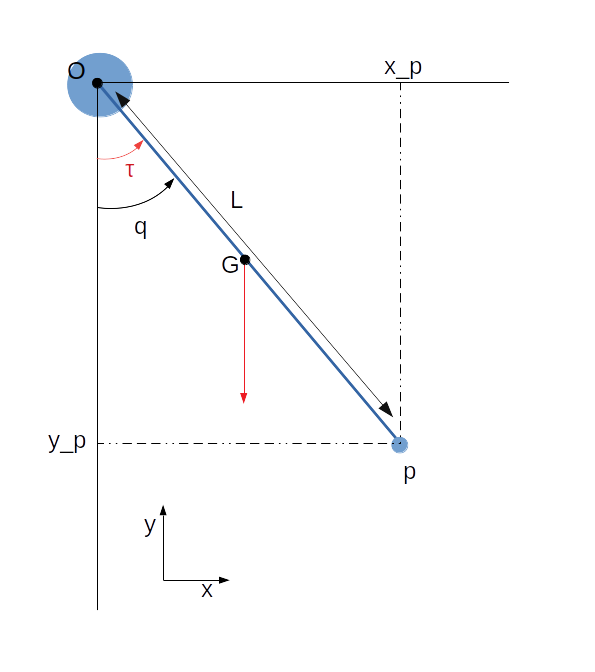

In [17]:
from IPython.display import Image

# Display the 1R robot
Image("1dof-dyn.png")

# Need to change the figure : gravity acts at the tip of the rod (not the middle) + change equations

Neglecting the actuator's dynamics, the rotational joint in $O$ can be viewed as a pure torque source. This torque $\tau$, together with the effect of gravity, generates an angular acceleration $\ddot{q}$. These two quantities satisfy [Euler's law](https://en.wikipedia.org/wiki/Euler%27s_laws_of_motion) :

$$
\tau + \sum \vec{M}_O(\vec{F}) = I \ddot{q}
$$

where 
- $ \sum \vec{M}_O(\vec{F})$ represent the sum of the moments of external forces applied on the robot, taken with respect to the base / origin point $O$
- $I$ is the [inertia](https://en.wikipedia.org/wiki/List_of_moments_of_inertia) of the link (in $kg.m^2.s^2$)

Here the only external force applied on the robot is gravity, acting at the center of mass $G$ and given by $\vec{F}_{gravity} = -mg \vec{y}$ (red arrow in the picture). 

__Question__ : Assuming that $\|\vec{OG}\| = L$, what it the moment due to gravity about $O$ ? 

Hint: Use the definition of the [moment of a force about a point](https://www.miniphysics.com/moment-of-force.html)

__Answer__ : The moment of gravity about $O$ is by definition

$$
\vec{M}_O(\vec{F}_{gravity}) = \vec{OG} \times \vec{F}_{gravity} = -Lmg\sin(q)
$$

__Question__ : Knowing the moment of gravity, how to deduce the DDM / IDM ?

__Answer__ : $\tau$ and $\ddot{q}$ are related as

$$
\tau -Lmg\sin(q) = I \ddot{q}
$$

From this equation, it is easy to deduce the DDM and IDM. Given the joint space motion of the 1R robot, the IDM explains which torque is exerted on the joint 

$$
\tau = I \ddot{q} + Lmg\sin(q)
$$

Conversely, inverting this model yields the DDM which predicts the joint space motion caused by a given torque

$$
\ddot{q} = \frac{1}{I}(\tau - Lmg\sin(q))
$$

__Question__ : The class below implements the DDM and IDM of the 1R robot. Complete the code. Use $I=\frac{1}{3}mL^2$.

In [18]:
class DynamicModel1R:
    
    def __init__(self, length, mass):
        '''
        This function initialises the class OneDOFManipulatorEnv
        Input:
            length : lenght of the arm
            mass : mass of the rod
        '''
        
        self.L = length
        self.dt = 0.001 # discretization step in seconds
        self.g = 9.81 # gravity vector
        self.m = mass
        # Computing the intertia of the rod about an axis
        # fixed at the end (1/3)ml^2
        self.I = (1/3)*self.m*(self.L**2)
        
    def DDM(self, q, v, tau):
        '''
        This function computes the direct dynamics model (DDM) of the manipulator given
        the current state of (Joint Position q, Joint Velocity v) and torque tau
        Input:
            q   : joint position 
            v   : joint velocity
            tau : joint torque
        Output:
            a   : joint acceleration
        '''
        
        q_rad = (np.pi/180)*q # converting from degree to radians
        return v, (tau - self.m*self.g*np.sin(q_rad))/self.I

    def IDM(self, q, v, a):
        '''
        This function computes the inverse dynamics model (IDM) of the manipulator given
        the current state of (Joint Position q, Joint Velocity v) and acceleration a
        Input:
            q : joint position 
            v : joint velocity
            a : joint acceleration
        Output:
            tau : joint torque
        '''
        
        q_rad = (np.pi/180)*q # converting from degree to radians
        return self.I*a + self.L*self.m*self.g*np.sin(q_rad)

The DDM is a _continuous-time_ Ordinary Differential Equation (ODE) : it describes the evolution of the robot based a time variable $t$ that is a real number: $t\in\mathbb{R}$. The dynamics of the 1R robot implemented above can be written equivalently as the continuous time ODE

$$
\dot x(t) = f(x(t),u(t))~~~\text{for}~t\in\mathbb{R} 
$$

where $x=[q,v]^T$ is the _state_ of joint positions and velocities, $u=\tau$ is the _control_ torque and $t$ is the _continuous time variable_. Given a control input __trajectory__ $u(t)$ (i.e. a joint torque signal), the _solution_ to this ODE is a state __trajectory__ $x(t)$ (i.e. joint position and velocity signals).

__Question__ : Write the continuous-time ODE in matrix form using the given definitions of the state and control variables. It should look like 

$$
\dot x = \begin{bmatrix} 
            f_1(x) \\
            f_2(x,u)
         \end{bmatrix}
$$ 

where $f_1,f_2$ are functions to be determined from the DDM.

__Hint__ : The left-hand side is $\dot x = [\dot q, \dot v]^T$, and we know that by definition $\dot v = \ddot q$ (joint acceleration). Use the DDM equation found earlier (and some logic) to deduce what $f_1,f_2$ should be in the right-hand side.

__Answer__ : Using the hint, we find the ODE to be

$$
\dot x = \begin{bmatrix} 
            \dot q \\
            \dot v
         \end{bmatrix}
       = \begin{bmatrix} 
            v \\
            \frac{1}{I}(\tau - Lmg\sin(q))
         \end{bmatrix}
$$ 
i.e. $f_1(x) = v$ and $f_2(x,u) = \frac{1}{I}(\tau - Lmg\sin(q))$ . 

In order to be able to simulate the system in a program, we need to discretize this continuous-time ODE into a _discrete-time_ ODE where $t=1,2,...$ (i.e. where $t$ is an integer). This procedure is called _discretization_ (or _integration_) and is crucial to understand how simulations work. The [Euler discretization](https://en.wikipedia.org/wiki/Euler_method) with timestep $\Delta t>0$ (expressed in seconds). of the DDM ODE transforms it into 

$$
x_{n+1} = x_n + f(x_n,u_n)\Delta t~~~\text{for}~n=0,1,2,...
$$

which is a good approximation of the continuous time model whenever $\Delta t$ is small. Given a control input __sequence__ $u_0,u_1,...$ (i.e. a joint torque sequence), the _solution_ to this discrete ODE is a state __sequence__ $x_0, x_1, ...$ (i.e. joint position and velocity sequences). We will use this discretized model to simulate robot, that is to calculate the sequence of $x_n$'s given an initial state $x_0$ and a finite control sequence $u_0,...,u_N$.   

__Question__ : Say we chose some $\Delta t$ and a number of simulation steps $N$. What does the quantity $N\Delta t$ represent?

__Answer__ : It represents the total time duration of the simulation in seconds. For instance if we simulate $N=1000$ steps with a discretization timestep of $\Delta t = 0.001s$ then we are simulating the system over a total duration of $1s$.

__Question__ : Implement a member function `step` in the class `DynamicModel1R` that implements the discrete time ODE shown above. It should take the current state $x_n$, control $u_n$ and discretization step $\Delta t$ as an input and return the next state $x_{n+1}$.

__Hint__ : In your implementation, use the DDM.

In [19]:
class DynamicModel1R:
    
    def __init__(self, length, mass):
        '''
        This function initialises the class OneDOFManipulatorEnv
        Input:
            length : lenght of the arm
            mass : mass of the rod
        '''
        
        self.L = length
        self.dt = 0.001 # discretization step in seconds
        self.g = 9.81 # gravity vector
        self.m = mass
        # Computing the intertia of the rod about an axis
        # fixed at the end (1/3)ml^2
        self.I = (1/3)*self.m*(self.L**2)
        
    def DDM(self, q, v, tau):
        '''
        This function computes the direct dynamics model (DDM) of the manipulator given
        the current state of (Joint Position q, Joint Velocity v) and torque tau
        Input:
            q   : joint position 
            v   : joint velocity
            tau : joint torque
        Output:
            a   : joint acceleration
        '''
        
        q_rad = (np.pi/180)*q # converting from degree to radians
        return v, (tau - self.m*self.g*np.sin(q_rad))/self.I

    def IDM(self, q, v, a):
        '''
        This function computes the inverse dynamics model (IDM) of the manipulator given
        the current state of (Joint Position q, Joint Velocity v) and acceleration a
        Input:
            q : joint position 
            v : joint velocity
            a : joint acceleration
        Output:
            tau : joint torque
        '''
        
        q_rad = (np.pi/180)*q # converting from degree to radians
        return self.I*a + self.L*self.m*self.g*np.sin(q_rad)
    
    def step(self, q_n, v_n, tau_n, dt):
        '''
        This function integrates the dynamics of the manipulator for one time step of duration dt 
        using the Euler discretization method
        Input:
            q_n   : joint position at current time step n
            v_n   : joint velocity at current time step n
            tau_n : torque applied at the end of manipulator at current time step n
            dt    : Euler discretization step (the "Delta t")
        '''
        
        v_n, a_n = self.DDM(q_n, v_n, tau_n)
        
        q_np1 = q_n + v_n*self.dt
        v_np1 = v_n + a_n*self.dt
        
        return q_np1, v_np1

Now we have all the ingredients to simulate the 1R robot ! 

__Question__ : Using the `DynamicModel1R.step` function you just implemented, write a python script that 
- instantiates the `DynamicModel1R` class 
- given some initial state $x_0 = [q_0,v_0]^T$ of your choice, it simulates a user-defined control sequence $u_0,u_2...,u_N$ where $N$ is the total number of steps in the trajectory
- stores the trajectory obtained with the simulation $x_0=[q_0,v_0]^T, ..., x_{N+1}=[q_{N+1},v_{N+1}]^T$ (output of the `step` function) 
- plots nicely the control and state trajectories with legend, titles, axis titles, etc.

Try first with a zero torque sequence, i.e. $u_0,...,u_N = 0,...,0$. Set $\Delta t=0.001s$ and $N=10000$ ($10s$ simulation). Then feel free to try out different values of $N$ and $\Delta t$ and to change the control sequence.

__Hint__ : Use a `for` loop on $N$ and call `DynamicModel1R.step` at each cycle.

__Answer__ :

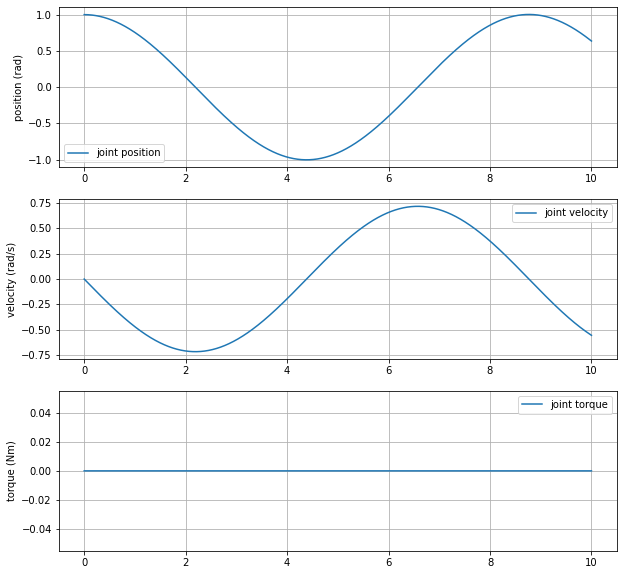

In [20]:
# Create robot model
model = DynamicModel1R(1, 1)
# Number of simulation steps 
N = 10000
# Euler discretization step 
dt = 0.001
# Control sequence u_n = tau_n = 0 for n=0,1,...,N
u_seq = np.zeros(N)
# State sequence x_n = (q_n, v_n) for n=0,1,...,N+1
x_seq = np.zeros((N+1,2))
  # Set x_0 
x_seq[0,0] = 1. # initial position
x_seq[0,1] = 0. # initial velocity

for i in range(N):
    # Get next state 
    q,v = model.step(x_seq[i,0], x_seq[i,1], u_seq[i], dt)
    # Record it
    x_seq[i+1,:] = np.array([q,v])

# Plot sequences
fig, axs = plt.subplots(3,1, figsize = (10, 10))
axs[0].plot(np.linspace(0,(N+1)*dt, N+1), x_seq[:,0], label = 'joint position')
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel("position (rad)")

axs[1].plot(np.linspace(0,(N+1)*dt, N+1), x_seq[:,1], label = 'joint velocity')
axs[1].grid()
axs[1].legend()
axs[1].set_ylabel("velocity (rad/s)")

axs[2].plot(np.linspace(0,N*dt, N), u_seq, label = 'joint torque')
axs[2].grid()
axs[2].legend()
axs[2].set_ylabel("torque (Nm)")

plt.show()

Now the torque sent to the 1R robot doesn't seem to achieve anything special. This is because we input "random" joint torques... What if we want to generate, say, a circle trajectory as we did using the kinematic planner ? Which torque to sequence to use in this case ? The IDM can be used for this purpose: this technique is called __inverse dynamics__. It gives us the torque $\tau$ that must be applied to achieve a desired motion $q,\dot{q},\ddot{q}$.

__Question__ : Using the class `DynamicModel1R`, write a script that : 
- Calculates the sequence of torques realizing a circle trajectory with $\ddot q = 0$ (__Hint__: first, use the `Model1R` and `KinematicPlanner` classes from the previous Notebook to determine the desired $q,\dot{q}$).
- Simulate the obtained sequence of torque and plot everything (__Hint__: you can use the script from the previous question)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABXa21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABedZYiE
ADf//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAA33SOPPLGIDMBRPF7nsmLmccrt1UoZXhLY
p7N9LuGK9NVbfNwYui+erZSJyzg0kp5T0f2VbDgYU86hnYiu9AAAUc0e5O6HqWXnsbPjbwXP0O9E
eEHh3KKtgcflOOhqZYi6ER0ahYHMZx7psIY+mtwar/BeT0x/UFH9+BsSvAj66Um7/CNmmjj2159x
aEnb5MsIbDdcn2os3WB3p43dbf53+Q70w2zH2PeWZkYpJdb7XblrvjGYU2MG8/LbEw4GDGb4+HhN
D9k4X3ChIsYFTEHefc8R5FaQxyqKcZ+wKrdfBJqT9IS2AN1LnUiw6/mNx/LkBhLfdyPl7wa9N53M
k4dsDXHMZchee7UzGO6oN0NC22cQWjJeBP53JkKsEpQ3WZGXkOs9hEDdwltpnV/A6qB/qRpvSIGs
Lo5QzjiXvy7uiaihhuFA4tpMXPP3YpVPAR15j/D+YwsOvArJyjmLBTulKWSz9JrRtiaNfmoPVqKS
gvWdGzi6zuvwwVPc3MYLCK2pPTSq7peTtDTww2A2vAMbNMZfdWUWspM9DPjPjCF0HkA7pMi6/Q3z
UCVDFlYanRTopdNgQcmaPj5Lbp8fogs1TvVLPDzwhL/nRLTK/zZ5LUs5k4ZUswW8bvSp1Anl4oAq
jDJuny3Rx0BFxHxpJuozSCDN69aGromK4zE7mRFFIEQgNLw+1djPcw1UbstteSBr1fIvepGh6YyY
LiLMW+b4n0mEcOSXkHYsQCLh7hMlko5mJvqXHqtL+vaYo7DdTkDB3uLvn/7FUejb6z/TCQ546OB/
GmD539iOdCb4iH+aq8M+kfLoBQhjVs95+f/cOR1+I3l90g75FaxygeEJ2ghrXX+MNrCPcer0/ia4
v4h2NnOhWWg8dSbtc/Q3dvgYp4f4hf37Pxx9oLSc+35Nb6mhlU6oWOYhaJYhOFR6hjXpkjw6SHG6
PLLD7AGj58zkL2vNOpxtSpviQl03txRHyB+zKuttv6vC6jnFrTZPxL5dj1MDXFgok5I4yjOogfCL
xyNsZo33IycqxmciXrFtuFYjgPQtR8Uj4F/+SyziInkK8sze6MXbyc4QJy45U7lu+baD6s5v/6Kz
B+zyq7l8k/H98XQeEwXdl82CN6a9GjeTWVgdrpP2DXKLAo6XF3C4a7y6LT6ehU7PRcNSCbi1LABf
m13U90BbjCLudGyOa/2GQQsPwaniFu/DQomQOGHWl891PLxAXo+ruewebaCECUTyq/0jgQWn+P4a
ide5xHJNBAZrtGlvJXtMXDrsXWkjpo8mJMPBo0tETkJjqnOQ48cfRdOLsUWBa0gJBPEZ/3vB6Utg
B45SVZK4nmiZrBwPl3gL6OpEGc9jNmAx3uS3cgeXqZbqJPhJwkeNvW5Fh6tnNprqDkkqbM/CZL3W
PfR3TwvkCRPoPG/wWiz2xyuf2Me31WSLasHSj20bGJFVYC0brAU6MBhmmL8jvxkO2hWv1T1/hI3b
1RHAfRpdsmCgo5riSfM6TjiIvt6xx9fYWo9nSdtpTr3lAxqAIY3/lVw1oePLTpurquymGklDo9ec
46lXDKljKcKc7UhTVXPTIN7wViIOQylUCNSsKwwl4owIMo7vBVJRela2EC0ALx7fTtKUzS9EGgzr
fauMJS5CMNAib0Wv5m5LRqLhKQCVh0fux5zRIs+VsQ5ggKct6T0+g0uzVhlTQIsevn7uKg6pl+E/
sZMuyPM2QJtwah9fWGIbtvblsO3Rjw9SeTfoE7f0OgCnlHVbwV0eAOPdflvVDthaLRfEMwn941ip
WC7wn0+6y+0z60D2ywqE9SRBl5TC6Qs6IiABGbTLa2BFos0BAYlGk4Chk6sdhDgwG+UIlJGqBalb
OmHtMjbR/xZQmzzGq/8qMrTG1HEpcJJ9I5khT9NwvzaTIaYDrbWGcaDMmDe/6YVGJpTQlEq4+2GL
/IJh4kZTuXPvQe8vRB9JezSCYCwuxeyhhWYGx17s9xpYeBmT4yrf4y9F1/N+ZEubZvmsaviz3WOV
Lqhr5WG6IozoJrl8Mn9sfsx/qr6FOvbf8G44ZOXr/9SDYWQ1H1Ra9pqJl1+dG+FrklUTPrbFe1OE
xZkzxkGCSEca8V+iRXab9tj5mze9bsvaKld1+66vrrZXbsOfoV0IKLo+sB3v64DCxvFKzxptMv4N
yYwR+7Nd//kZQ6kKRKknWnnxr0NvKMGlaJT6OF+45/mGe4k+CIXWyapZi9yy3bw2RGAc4jmbfBjj
xqqqQUhWfeB30Z/qgYzZdhx46HbzlVm55IGFp1MiFfS5ZcZ9OZH07/qOGnHvoWLvpJWJttxod3JQ
/TGXMUTvP6b01avDYoyDhimQH6feAEk4QI/vYpiCS1PtW4VcPmXeskNvw1/oKZkuOE9jIl+Pm8m5
BHOX/BkICPX+aFV1HI6zDGahL6cbqIPZJm2+JniWKNLaL19gs+OyVruvanjKcQb+VXP51CxZcZAS
MV/oTIkc8rRi9nodDI6ZoAzS+lIOO0b+fiayjcPTTyfzpOWUeha0fPBN2qgXZV+ZIyj4sFvRFh1y
VQqbYqPoHTchbSUEyynpHzuU9T5EJLe2s6V70ml2xqB+vbxB90dtEkA5182Yj1xVpsBk3U0jK0CG
z57UBK7qJIJsCDJ6NUU4z+9xXv/dPIN1SOHg4JOpsVgQyuZLjENWLUwL3DbVycE+Ioky8MSLytrs
ztY5lgxoF0mQa1buGYWJwmr9IjEKY840p4ITQbIdlSyI277G65Mvroc9GObbvweJ+MHhXSv4Bp0u
eZAC/b1mtcRyFFbhZXfbXy0o7mN93yajiJNm6tXPSwAV5ztt13qF31lfZ/Ffiw1lKNpqQ0/GnCkY
QC4pmjim1SGOS/suwcWuf

[0.         0.06346652 0.12693304 0.19039955 0.25386607 0.31733259
 0.38079911 0.44426563 0.50773215 0.57119866 0.63466518 0.6981317
 0.76159822 0.82506474 0.88853126 0.95199777 1.01546429 1.07893081
 1.14239733 1.20586385 1.26933037 1.33279688 1.3962634  1.45972992
 1.52319644 1.58666296 1.65012947 1.71359599 1.77706251 1.84052903
 1.90399555 1.96746207 2.03092858 2.0943951  2.15786162 2.22132814
 2.28479466 2.34826118 2.41172769 2.47519421 2.53866073 2.60212725
 2.66559377 2.72906028 2.7925268  2.85599332 2.91945984 2.98292636
 3.04639288 3.10985939 3.17332591 3.23679243 3.30025895 3.36372547
 3.42719199 3.4906585  3.55412502 3.61759154 3.68105806 3.74452458
 3.8079911  3.87145761 3.93492413 3.99839065 4.06185717 4.12532369
 4.1887902  4.25225672 4.31572324 4.37918976 4.44265628 4.5061228
 4.56958931 4.63305583 4.69652235 4.75998887 4.82345539 4.88692191
 4.95038842 5.01385494 5.07732146 5.14078798 5.2042545  5.26772102
 5.33118753 5.39465405 5.45812057 5.52158709 5.58505361 5.648520

ValueError: setting an array element with a sequence.

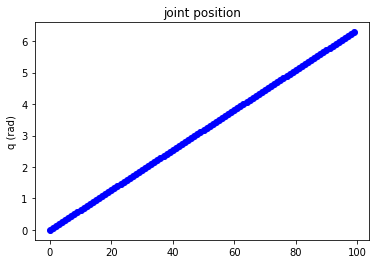

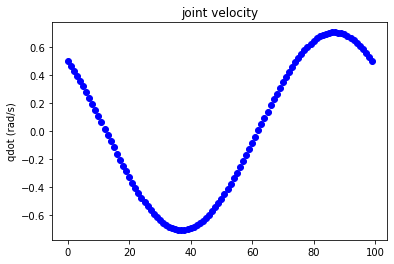

In [24]:
# New values to speed up simulation
N = 100
dt = 0.1

## PLAN TRAJECTORY using KINEMATICS
# Using results from the previous notebook
from models import Model1R, KinematicPlanner
# Create kinematic model
model1R = Model1R()
# Create kinematic planner
planner1 = KinematicPlanner(model1R)
# Plan
  # Desired end-effector positions p1,...,pN = circle 
x_p = np.cos(np.linspace(0,1,N)*2*np.pi)
y_p = np.sin(np.linspace(0,1,N)*2*np.pi)
p = np.array([x_p, y_p])
  # Desired end-effector velocities pdot1,...,pdotN = constant v
v = .5
pdot = v*np.array([np.ones(N)]*2)
q, qdot = planner1.plan(p, pdot)
# Animate 
model1R.animate(q)
# Plot the joint trajectories
plt.figure()
plt.plot(q[0,:], 'bo')
plt.title("joint position")
plt.ylabel("q (rad)")
    # qdot
plt.figure()
plt.plot(qdot[0,:], 'bo')
plt.title("joint velocity")
plt.ylabel("qdot (rad/s)")

## FIND TORQUE using INVERSE DYNAMICS
# Create robot model
model = DynamicModel1R(1, 1)
# Get torques using IDM 
u_seq = np.zeros(N)
for i in range(N):
    print(q[i,:], qdot[i,:])
    print(model.IDM(q[i,:], qdot[i,:], 0.))
    u_seq[i] = model.IDM(q[i,:], qdot[i,:], 0.) # kinematic plan + 0 acceleration
# Simulate resulting control sequence (use previous question's script)
# State sequence x_n = (q_n, v_n) for n=0,1,...,N+1
x_seq = np.zeros((N+1,2))
  # Set x_0 
x_seq[0,0] = q[0,:] # initial position
x_seq[0,1] = qdot[0,:] # initial velocity

for i in range(N):
    # Get next state 
    q,v = model.step(x_seq[i,0], x_seq[i,1], u_seq[i], dt)
    # Record it
    x_seq[i+1,:] = np.array([q,v])

# Plot sequences
fig, axs = plt.subplots(3,1, figsize = (10, 10))
axs[0].plot(np.linspace(0,(N+1)*dt, N+1), x_seq[:,0], label = 'joint position')
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel("position (rad)")

axs[1].plot(np.linspace(0,(N+1)*dt, N+1), x_seq[:,1], label = 'joint velocity')
axs[1].grid()
axs[1].legend()
axs[1].set_ylabel("velocity (rad/s)")

axs[2].plot(np.linspace(0,N*dt, N), u_seq, label = 'joint torque')
axs[2].grid()
axs[2].legend()
axs[2].set_ylabel("torque (Nm)")

plt.show()